In [3]:
import syft as sy
import os
from os import path
import urllib.request
import gzip
import struct
import array
import matplotlib.pyplot as plt
from datasets import mnist, mnist_raw
import numpy as np
import pandas as pd

print(f"{sy.__version__ = }")

sy.__version__ = '0.8.1-beta.11'


## 1. Launch the domain, upload the data

In [4]:
node = sy.orchestra.launch(name="dk-domain", dev_mode=True, reset=True)
root_client = node.login(email="info@openmined.org", password="changethis")

SQLite Store Path:
!open file:///tmp/7394e1ec94664623a12883a6a2443efa.sqlite



### Load the MNIST dataset

Let's load the raw MNIST images and show with the `mnist_raw` function from `datasets.py`

In [5]:
train_images, train_labels, test_images, test_labels = mnist_raw()

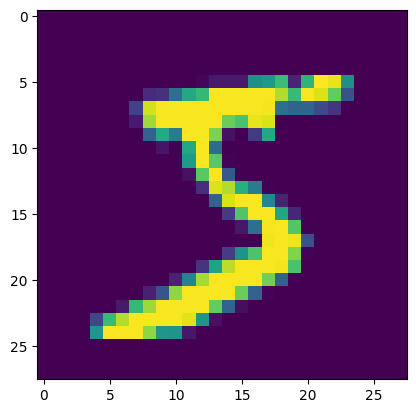

In [6]:
plt.imshow(train_images[0])

In [7]:
train_labels[0]

5

In [8]:
print(f"{train_images.shape = }")
print(f"{train_labels.shape = }")
print(f"{test_images.shape = }")
print(f"{test_labels.shape = }")

train_images.shape = (60000, 28, 28)
train_labels.shape = (60000,)
test_images.shape = (10000, 28, 28)
test_labels.shape = (10000,)


Let's flatten the MNIST images and apply one-hot encoding on the labels using the `mnist` function from `datasets.py`

In [9]:
train_images, train_labels, test_images, test_labels = mnist()

Get a subset of MNIST

In [10]:
num_samples = 100

In [11]:
train_images = train_images[:num_samples, :] 
train_labels = train_labels[:num_samples, :]

In [12]:
print(f"{train_images.shape = }")
print(f"{train_labels.shape = }")

train_images.shape = (100, 784)
train_labels.shape = (100, 10)


The `train_images` and `train_labels` are the private data. Let's create similar mock data with the same shape

In [13]:
mock_images = np.random.rand(num_samples, 784)
mock_images.shape

(100, 784)

In [14]:
mock_labels = np.eye(10)[np.random.choice(10, num_samples)]
mock_labels.shape

(100, 10)

In [15]:
assert mock_labels.shape == train_labels.shape
assert mock_images.shape == train_images.shape

### Create the dataset, upload the data

In [16]:
dataset = sy.Dataset(
    name="MNIST data",
    description="""Contains the flattened training images and one-hot encoded training labels.""",
    url="https://storage.googleapis.com/cvdf-datasets/mnist/"
)

dataset.add_contributor(role=sy.roles.UPLOADER, 
                        name="Alice", 
                        email="alice@openmined.com",
                        note="Alice is the data engineer at the OpenMined")

dataset.contributors

[syft.service.dataset.dataset.Contributor]

In [17]:
asset_mnist_train_input = sy.Asset(
    name="MNIST training images",
    description="""The training images of the MNIST dataset""",
    data=train_images,
    mock=mock_images
)

asset_mnist_train_labels = sy.Asset(
    name="MNIST training labels",
    description="""The training labels of MNIST dataset""",
    data=train_labels,
    mock=mock_labels
)

dataset.add_asset(asset_mnist_train_input)
dataset.add_asset(asset_mnist_train_labels)

In [18]:
root_client.upload_dataset(dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.17it/s]


Uploading: MNIST training images
Uploading: MNIST training labels


<class 'syft.service.response.SyftSuccess'>: Dataset Added

Let's inspect the uploaded data

In [19]:
datasets = root_client.api.services.dataset.get_all()
# assert len(datasets) == 1
# datasets

In [26]:
datasets[0].assets[0]

syft.service.dataset.dataset.Asset

### Create an account for the Data Scientist (DS)

In [27]:
root_client.register(name="Sheldon Cooper",
                     email="sheldon@caltech.edu",
                     password="changethis",
                     institution="Caltech",
                     website="https://www.caltech.edu/")

<class 'syft.service.response.SyftSuccess'>: User Sheldon Cooper successfully registered! To see users, run client.users.

#### Now switch to the DS's notebook